In [1]:
%load_ext autoreload
%autoreload 2

In [47]:
# latent space

from src.trainer import VertexTrainer
trainer = VertexTrainer(project_name='vertex_v2', config_name='confmod_auto_encoder_v2.json', 
                        subconfig_name='AUTO_ENCODER_VERTEX_V2')
ls = trainer.load_latentspace('saves/vertex_v2/save_AUTO_ENCODER_VERTEX_V2_BS20_2024-12-06/version_0')
ls.shape

(576, 576, 128)

In [ ]:
# generate slurm
from src import util


trainer_kwargs = {
    'project_name': 'vertex_v2', 
    'config_name': 'confmod_auto_encoder_v2.json', 
    'subconfig_name': 'AUTO_ENCODER_VERTEX_V2', 
    'config_kwargs': {
        'subset': 10, 
        'subset_shuffle': True, 
        'subset_seed': 42,
    },
}
util.slurm_generate.create(project_name='vertex_v2', script_name='vsc_test', 
                           pyenv_dir='/gpfs/data/fs71925/shepp123/anaconda3',
                           pyenv_name='conda_ml24_1', path_to_repo='/gpfs/data/fs71925/shepp123', 
                           trainer='VertexTrainer', trainer_kwargs=trainer_kwargs)


In [ ]:
# create slurm- and train-script from config-file
!python src/util/slurm_generate.py configs/confmod_auto_encoder_v2.json

In [ ]:
##################    24^6 MATRIX    ##################

In [421]:
### prepare
import random
import time
import numpy as np


def print_mat_stats(m):
    print(f'dim: {len(m.shape)}, shape: {m.shape}, size: {m.size}, sum: {m.sum()}')
    #print(m)

random.seed(42)
np.random.seed(42)

n_freq = 24
space_dim = 2
k_dim = 3
dim = space_dim * k_dim
length = n_freq**space_dim

#m576_3 = np.ones((length,) * k_dim)
m576_3 = np.random.rand(*((length,) * k_dim))
m24_6 = np.zeros((n_freq,) * dim)
print_mat_stats(m576_3)
print_mat_stats(m24_6)

dim: 3, shape: (576, 576, 576), size: 191102976, sum: 95551209.18438378
dim: 6, shape: (24, 24, 24, 24, 24, 24), size: 191102976, sum: 0.0


In [426]:
########################            OPTION 1 (slower)            ########################
t0 = time.time()

random.seed(42)

x_first = True
if x_first:
    def transform_index(i: int) -> tuple[int, int]:
        return (i % n_freq, i // n_freq)
else:
    def transform_index(i: int) -> tuple[int, int]:
        return (i // n_freq, i % n_freq)

def transform_indices(*indices: int) -> list[int]:
    return [j for i in indices for j in transform_index(i)]

# unpack to 24^6 matrix
m24_6 = np.empty((n_freq,) * dim)
k = np.arange(length)
for i_k1 in range(length):
    for i_k2 in range(length):
        m24_6[*transform_indices(i_k1, i_k2), k % n_freq, k // n_freq] = m576_3[i_k1, i_k2, :]

# sample `sample_count_per_vertex` random indices of a 24^6 matrix
n_samples = 1000
indices = random.sample(range(n_freq**dim), n_samples)
indices = np.array([[(x // n_freq**i) % n_freq for i in range(dim)] for x in indices])

# Retrive and merge all row combinations by the sampled indices
merged_slices = np.array([[*m24_6[k1x, k1y, k2x, k2y, k3x, :], 
                            *m24_6[k1x, k1y, k2x, k2y, :, k3y], 
                            *m24_6[k1x, k1y, k2x, :, k3x, k3y], 
                            *m24_6[k1x, k1y, :, k2y, k3x, k3y], 
                            *m24_6[k1x, :, k2x, k2y, k3x, k3y], 
                            *m24_6[:, k1y, k2x, k2y, k3x, k3y]] for k1x, k1y, k2x, k2y, k3x, k3y in indices])

print(f'\ntime: {time.time() - t0:.3f}s\n')
print_mat_stats(merged_slices)
print(merged_slices)


time: 7.627s

dim: 2, shape: (1000, 144), size: 144000, sum: 72092.5813524723
[[0.91757029 0.09420702 0.52066351 ... 0.27125389 0.49286907 0.51091812]
 [0.16254951 0.67446905 0.69138893 ... 0.80333309 0.57821124 0.03437346]
 [0.88137176 0.53878277 0.85550108 ... 0.22589571 0.62018019 0.27311903]
 ...
 [0.67133254 0.11798547 0.46779146 ... 0.42761258 0.46266912 0.70602822]
 [0.44008561 0.94552993 0.32230139 ... 0.9784332  0.12836095 0.7196447 ]
 [0.0839593  0.79263784 0.6897323  ... 0.16261618 0.19331984 0.15043626]]


In [432]:
########################            OPTION 2 (fast)            ########################
t0 = time.time()

random.seed(42)

# sample `sample_count_per_vertex` random indices of a 24^6 matrix
n_samples = 1000
indices = random.sample(range(n_freq**dim), n_samples)
indices = np.array([[(x // n_freq**i) % n_freq for i in range(dim)] for x in indices])

# Retrive and merge all row combinations by the sampled indices
l_idcs = np.arange(length)
merged_slices = np.array([[*m576_3[k1x + 24 * k1y, k2x + 24 * k2y, l_idcs % n_freq == k3x],
                           *m576_3[k1x + 24 * k1y, k2x + 24 * k2y, l_idcs // n_freq == k3y], 
                           *m576_3[k1x + 24 * k1y, l_idcs % n_freq == k2x, k3x + 24 * k3y], 
                           *m576_3[k1x + 24 * k1y, l_idcs // n_freq == k2y, k3x + 24 * k3y], 
                           *m576_3[l_idcs % n_freq == k1x, k2x + 24 * k2y, k3x + 24 * k3y],
                           *m576_3[l_idcs // n_freq == k1y, k2x + 24 * k2y, k3x + 24 * k3y]] 
                           for k1x, k1y, k2x, k2y, k3x, k3y in indices])

print(f'\ntime: {time.time() - t0:.3f}s\n')
print_mat_stats(merged_slices)
print(merged_slices)


time: 0.108s

dim: 2, shape: (1000, 144), size: 144000, sum: 72092.5813524723
[[0.91757029 0.09420702 0.52066351 ... 0.27125389 0.49286907 0.51091812]
 [0.16254951 0.67446905 0.69138893 ... 0.80333309 0.57821124 0.03437346]
 [0.88137176 0.53878277 0.85550108 ... 0.22589571 0.62018019 0.27311903]
 ...
 [0.67133254 0.11798547 0.46779146 ... 0.42761258 0.46266912 0.70602822]
 [0.44008561 0.94552993 0.32230139 ... 0.9784332  0.12836095 0.7196447 ]
 [0.0839593  0.79263784 0.6897323  ... 0.16261618 0.19331984 0.15043626]]


In [ ]:
########################################################

# Vertex Autoencoder

## Visualize

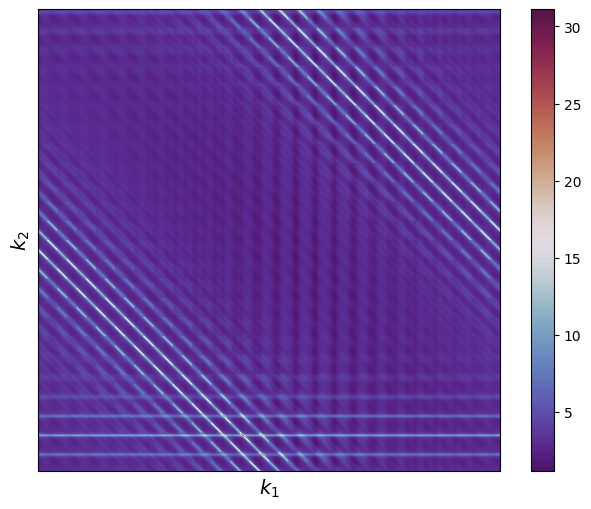

In [17]:
from src.load_data import AutoEncoderVertexV2
from src.visualization import vertex_visualization as vertvis

vertex = AutoEncoderVertexV2.load_from_file('../frgs/tp0.020000_mu0.080000.h5')
vertvis.plot_section(vertex, 255, axis=3, figsize=(8,6))

## Training

In [ ]:
from src.trainer import VertexTrainer, TrainerModes
trainer = VertexTrainer(project_name='vertex_v2', config_name='confmod_auto_encoder_v2.json', 
                        subconfig_name='AUTO_ENCODER_VERTEX_V2', 
                        config_kwargs={'subset': 10, 'subset_shuffle': False})

In [26]:
from src.trainer import VertexTrainer24x6, TrainerModes
trainer = VertexTrainer24x6(project_name='vertex_24x6', config_name='confmod_auto_encoder_v2.json', 
                            subconfig_name='AUTO_ENCODER_VERTEX_24X6', 
                            config_kwargs={'subset': None})

In [9]:
trainer.train(train_mode=TrainerModes.LOCAL)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | AutoEncoderVertex | 34.9 K | train
1 | criterion | MSELoss           | 0      | train
--------------------------------------------------------
34.9 K    Trainable params
0         Non-trainable params
34.9 K    Total params
0.140     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 240/240 [00:09<00:00, 24.94it/s, v_num=1, val_loss=2.400]

Epoch 0, global step 240: 'val_loss' reached 2.40434 (best 2.40434), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=0-step=240.ckpt' as top 10


Epoch 1: 100%|██████████| 240/240 [00:02<00:00, 108.91it/s, v_num=1, val_loss=2.300]

Epoch 1, global step 480: 'val_loss' reached 2.30100 (best 2.30100), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=1-step=480.ckpt' as top 10


Epoch 2: 100%|██████████| 240/240 [00:02<00:00, 108.57it/s, v_num=1, val_loss=2.230]

Epoch 2, global step 720: 'val_loss' reached 2.22852 (best 2.22852), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=2-step=720.ckpt' as top 10


Epoch 3: 100%|██████████| 240/240 [00:02<00:00, 107.04it/s, v_num=1, val_loss=2.120]

Epoch 3, global step 960: 'val_loss' reached 2.12218 (best 2.12218), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=3-step=960.ckpt' as top 10


Epoch 4: 100%|██████████| 240/240 [00:02<00:00, 108.40it/s, v_num=1, val_loss=1.950]

Epoch 4, global step 1200: 'val_loss' reached 1.94840 (best 1.94840), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=4-step=1200.ckpt' as top 10


Epoch 5: 100%|██████████| 240/240 [00:02<00:00, 112.38it/s, v_num=1, val_loss=1.710]

Epoch 5, global step 1440: 'val_loss' reached 1.70531 (best 1.70531), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=5-step=1440.ckpt' as top 10


Epoch 6: 100%|██████████| 240/240 [00:02<00:00, 111.63it/s, v_num=1, val_loss=1.440]

Epoch 6, global step 1680: 'val_loss' reached 1.43652 (best 1.43652), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=6-step=1680.ckpt' as top 10


Epoch 7: 100%|██████████| 240/240 [00:02<00:00, 111.70it/s, v_num=1, val_loss=1.280]

Epoch 7, global step 1920: 'val_loss' reached 1.27702 (best 1.27702), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=7-step=1920.ckpt' as top 10


Epoch 8: 100%|██████████| 240/240 [00:02<00:00, 113.14it/s, v_num=1, val_loss=1.090]

Epoch 8, global step 2160: 'val_loss' reached 1.09260 (best 1.09260), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=8-step=2160.ckpt' as top 10


Epoch 9: 100%|██████████| 240/240 [00:02<00:00, 111.35it/s, v_num=1, val_loss=0.945]

Epoch 9, global step 2400: 'val_loss' reached 0.94494 (best 0.94494), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=9-step=2400.ckpt' as top 10


Epoch 10: 100%|██████████| 240/240 [00:02<00:00, 105.74it/s, v_num=1, val_loss=0.854]

Epoch 10, global step 2640: 'val_loss' reached 0.85363 (best 0.85363), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=10-step=2640.ckpt' as top 10


Epoch 11: 100%|██████████| 240/240 [00:02<00:00, 104.18it/s, v_num=1, val_loss=0.795]

Epoch 11, global step 2880: 'val_loss' reached 0.79463 (best 0.79463), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=11-step=2880.ckpt' as top 10


Epoch 12: 100%|██████████| 240/240 [00:02<00:00, 109.48it/s, v_num=1, val_loss=0.766]

Epoch 12, global step 3120: 'val_loss' reached 0.76588 (best 0.76588), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=12-step=3120.ckpt' as top 10


Epoch 13: 100%|██████████| 240/240 [00:02<00:00, 110.02it/s, v_num=1, val_loss=0.734]

Epoch 13, global step 3360: 'val_loss' reached 0.73409 (best 0.73409), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=13-step=3360.ckpt' as top 10


Epoch 14: 100%|██████████| 240/240 [00:02<00:00, 107.19it/s, v_num=1, val_loss=0.706]

Epoch 14, global step 3600: 'val_loss' reached 0.70580 (best 0.70580), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=14-step=3600.ckpt' as top 10


Epoch 15: 100%|██████████| 240/240 [00:02<00:00, 109.93it/s, v_num=1, val_loss=0.675]

Epoch 15, global step 3840: 'val_loss' reached 0.67464 (best 0.67464), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=15-step=3840.ckpt' as top 10


Epoch 16: 100%|██████████| 240/240 [00:02<00:00, 112.90it/s, v_num=1, val_loss=0.644]

Epoch 16, global step 4080: 'val_loss' reached 0.64374 (best 0.64374), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=16-step=4080.ckpt' as top 10


Epoch 17: 100%|██████████| 240/240 [00:02<00:00, 110.86it/s, v_num=1, val_loss=0.614]

Epoch 17, global step 4320: 'val_loss' reached 0.61394 (best 0.61394), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=17-step=4320.ckpt' as top 10


Epoch 18: 100%|██████████| 240/240 [00:02<00:00, 112.40it/s, v_num=1, val_loss=0.584]

Epoch 18, global step 4560: 'val_loss' reached 0.58385 (best 0.58385), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=18-step=4560.ckpt' as top 10


Epoch 19: 100%|██████████| 240/240 [00:02<00:00, 107.09it/s, v_num=1, val_loss=0.558]

Epoch 19, global step 4800: 'val_loss' reached 0.55836 (best 0.55836), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=19-step=4800.ckpt' as top 10


Epoch 20: 100%|██████████| 240/240 [00:02<00:00, 110.66it/s, v_num=1, val_loss=0.533]

Epoch 20, global step 5040: 'val_loss' reached 0.53310 (best 0.53310), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=20-step=5040.ckpt' as top 10


Epoch 21: 100%|██████████| 240/240 [00:02<00:00, 113.53it/s, v_num=1, val_loss=0.514]

Epoch 21, global step 5280: 'val_loss' reached 0.51351 (best 0.51351), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=21-step=5280.ckpt' as top 10


Epoch 22: 100%|██████████| 240/240 [00:02<00:00, 112.26it/s, v_num=1, val_loss=0.496]

Epoch 22, global step 5520: 'val_loss' reached 0.49578 (best 0.49578), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=22-step=5520.ckpt' as top 10


Epoch 23: 100%|██████████| 240/240 [00:02<00:00, 112.46it/s, v_num=1, val_loss=0.484]

Epoch 23, global step 5760: 'val_loss' reached 0.48392 (best 0.48392), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=23-step=5760.ckpt' as top 10


Epoch 24: 100%|██████████| 240/240 [00:02<00:00, 113.49it/s, v_num=1, val_loss=0.473]

Epoch 24, global step 6000: 'val_loss' reached 0.47288 (best 0.47288), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=24-step=6000.ckpt' as top 10


Epoch 25: 100%|██████████| 240/240 [00:02<00:00, 113.66it/s, v_num=1, val_loss=0.462]

Epoch 25, global step 6240: 'val_loss' reached 0.46196 (best 0.46196), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=25-step=6240.ckpt' as top 10


Epoch 26: 100%|██████████| 240/240 [00:02<00:00, 112.50it/s, v_num=1, val_loss=0.451]

Epoch 26, global step 6480: 'val_loss' reached 0.45133 (best 0.45133), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=26-step=6480.ckpt' as top 10


Epoch 27: 100%|██████████| 240/240 [00:02<00:00, 112.95it/s, v_num=1, val_loss=0.443]

Epoch 27, global step 6720: 'val_loss' reached 0.44308 (best 0.44308), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=27-step=6720.ckpt' as top 10


Epoch 28: 100%|██████████| 240/240 [00:02<00:00, 108.98it/s, v_num=1, val_loss=0.437]

Epoch 28, global step 6960: 'val_loss' reached 0.43697 (best 0.43697), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=28-step=6960.ckpt' as top 10


Epoch 29: 100%|██████████| 240/240 [00:02<00:00, 108.58it/s, v_num=1, val_loss=0.427]

Epoch 29, global step 7200: 'val_loss' reached 0.42684 (best 0.42684), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=29-step=7200.ckpt' as top 10


Epoch 30: 100%|██████████| 240/240 [00:02<00:00, 111.45it/s, v_num=1, val_loss=0.421]

Epoch 30, global step 7440: 'val_loss' reached 0.42096 (best 0.42096), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=30-step=7440.ckpt' as top 10


Epoch 31: 100%|██████████| 240/240 [00:02<00:00, 103.89it/s, v_num=1, val_loss=0.410]

Epoch 31, global step 7680: 'val_loss' reached 0.40996 (best 0.40996), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=31-step=7680.ckpt' as top 10


Epoch 32: 100%|██████████| 240/240 [00:02<00:00, 111.45it/s, v_num=1, val_loss=0.402]

Epoch 32, global step 7920: 'val_loss' reached 0.40165 (best 0.40165), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=32-step=7920.ckpt' as top 10


Epoch 33: 100%|██████████| 240/240 [00:02<00:00, 113.40it/s, v_num=1, val_loss=0.399]

Epoch 33, global step 8160: 'val_loss' reached 0.39905 (best 0.39905), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=33-step=8160.ckpt' as top 10


Epoch 34: 100%|██████████| 240/240 [00:02<00:00, 110.54it/s, v_num=1, val_loss=0.388]

Epoch 34, global step 8400: 'val_loss' reached 0.38751 (best 0.38751), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=34-step=8400.ckpt' as top 10


Epoch 35: 100%|██████████| 240/240 [00:02<00:00, 115.23it/s, v_num=1, val_loss=0.377]

Epoch 35, global step 8640: 'val_loss' reached 0.37743 (best 0.37743), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=35-step=8640.ckpt' as top 10


Epoch 36: 100%|██████████| 240/240 [00:02<00:00, 115.81it/s, v_num=1, val_loss=0.370]

Epoch 36, global step 8880: 'val_loss' reached 0.37009 (best 0.37009), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=36-step=8880.ckpt' as top 10


Epoch 37: 100%|██████████| 240/240 [00:02<00:00, 115.76it/s, v_num=1, val_loss=0.362]

Epoch 37, global step 9120: 'val_loss' reached 0.36231 (best 0.36231), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=37-step=9120.ckpt' as top 10


Epoch 38: 100%|██████████| 240/240 [00:02<00:00, 116.63it/s, v_num=1, val_loss=0.355]

Epoch 38, global step 9360: 'val_loss' reached 0.35548 (best 0.35548), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=38-step=9360.ckpt' as top 10


Epoch 39: 100%|██████████| 240/240 [00:02<00:00, 114.71it/s, v_num=1, val_loss=0.349]

Epoch 39, global step 9600: 'val_loss' reached 0.34936 (best 0.34936), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=39-step=9600.ckpt' as top 10


Epoch 40: 100%|██████████| 240/240 [00:02<00:00, 116.67it/s, v_num=1, val_loss=0.343]

Epoch 40, global step 9840: 'val_loss' reached 0.34303 (best 0.34303), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=40-step=9840.ckpt' as top 10


Epoch 41: 100%|██████████| 240/240 [00:02<00:00, 112.72it/s, v_num=1, val_loss=0.335]

Epoch 41, global step 10080: 'val_loss' reached 0.33519 (best 0.33519), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=41-step=10080.ckpt' as top 10


Epoch 42: 100%|██████████| 240/240 [00:02<00:00, 109.59it/s, v_num=1, val_loss=0.331]

Epoch 42, global step 10320: 'val_loss' reached 0.33093 (best 0.33093), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=42-step=10320.ckpt' as top 10


Epoch 43: 100%|██████████| 240/240 [00:02<00:00, 110.37it/s, v_num=1, val_loss=0.325]

Epoch 43, global step 10560: 'val_loss' reached 0.32548 (best 0.32548), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=43-step=10560.ckpt' as top 10


Epoch 44: 100%|██████████| 240/240 [00:02<00:00, 108.69it/s, v_num=1, val_loss=0.318]

Epoch 44, global step 10800: 'val_loss' reached 0.31830 (best 0.31830), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=44-step=10800.ckpt' as top 10


Epoch 45: 100%|██████████| 240/240 [00:02<00:00, 109.71it/s, v_num=1, val_loss=0.313]

Epoch 45, global step 11040: 'val_loss' reached 0.31342 (best 0.31342), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=45-step=11040.ckpt' as top 10


Epoch 46: 100%|██████████| 240/240 [00:02<00:00, 111.78it/s, v_num=1, val_loss=0.304]

Epoch 46, global step 11280: 'val_loss' reached 0.30441 (best 0.30441), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=46-step=11280.ckpt' as top 10


Epoch 47: 100%|██████████| 240/240 [00:02<00:00, 114.46it/s, v_num=1, val_loss=0.299]

Epoch 47, global step 11520: 'val_loss' reached 0.29899 (best 0.29899), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=47-step=11520.ckpt' as top 10


Epoch 48: 100%|██████████| 240/240 [00:02<00:00, 116.09it/s, v_num=1, val_loss=0.295]

Epoch 48, global step 11760: 'val_loss' reached 0.29511 (best 0.29511), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=48-step=11760.ckpt' as top 10


Epoch 49: 100%|██████████| 240/240 [00:02<00:00, 115.00it/s, v_num=1, val_loss=0.291]

Epoch 49, global step 12000: 'val_loss' reached 0.29093 (best 0.29093), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=49-step=12000.ckpt' as top 10


Epoch 50: 100%|██████████| 240/240 [00:02<00:00, 115.20it/s, v_num=1, val_loss=0.285]

Epoch 50, global step 12240: 'val_loss' reached 0.28465 (best 0.28465), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=50-step=12240.ckpt' as top 10


Epoch 51: 100%|██████████| 240/240 [00:02<00:00, 110.68it/s, v_num=1, val_loss=0.280]

Epoch 51, global step 12480: 'val_loss' reached 0.27985 (best 0.27985), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=51-step=12480.ckpt' as top 10


Epoch 52: 100%|██████████| 240/240 [00:02<00:00, 112.27it/s, v_num=1, val_loss=0.273]

Epoch 52, global step 12720: 'val_loss' reached 0.27320 (best 0.27320), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=52-step=12720.ckpt' as top 10


Epoch 53: 100%|██████████| 240/240 [00:02<00:00, 109.97it/s, v_num=1, val_loss=0.268]

Epoch 53, global step 12960: 'val_loss' reached 0.26842 (best 0.26842), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=53-step=12960.ckpt' as top 10


Epoch 54: 100%|██████████| 240/240 [00:02<00:00, 111.42it/s, v_num=1, val_loss=0.263]

Epoch 54, global step 13200: 'val_loss' reached 0.26308 (best 0.26308), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=54-step=13200.ckpt' as top 10


Epoch 55: 100%|██████████| 240/240 [00:02<00:00, 112.60it/s, v_num=1, val_loss=0.260]

Epoch 55, global step 13440: 'val_loss' reached 0.26042 (best 0.26042), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=55-step=13440.ckpt' as top 10


Epoch 56: 100%|██████████| 240/240 [00:02<00:00, 111.33it/s, v_num=1, val_loss=0.258]

Epoch 56, global step 13680: 'val_loss' reached 0.25792 (best 0.25792), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=56-step=13680.ckpt' as top 10


Epoch 57: 100%|██████████| 240/240 [00:02<00:00, 113.04it/s, v_num=1, val_loss=0.250]

Epoch 57, global step 13920: 'val_loss' reached 0.24955 (best 0.24955), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=57-step=13920.ckpt' as top 10


Epoch 58: 100%|██████████| 240/240 [00:02<00:00, 112.27it/s, v_num=1, val_loss=0.244]

Epoch 58, global step 14160: 'val_loss' reached 0.24352 (best 0.24352), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=58-step=14160.ckpt' as top 10


Epoch 59: 100%|██████████| 240/240 [00:02<00:00, 110.14it/s, v_num=1, val_loss=0.240]

Epoch 59, global step 14400: 'val_loss' reached 0.24037 (best 0.24037), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=59-step=14400.ckpt' as top 10


Epoch 60: 100%|██████████| 240/240 [00:02<00:00, 112.56it/s, v_num=1, val_loss=0.237]

Epoch 60, global step 14640: 'val_loss' reached 0.23743 (best 0.23743), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=60-step=14640.ckpt' as top 10


Epoch 61: 100%|██████████| 240/240 [00:02<00:00, 108.62it/s, v_num=1, val_loss=0.232]

Epoch 61, global step 14880: 'val_loss' reached 0.23166 (best 0.23166), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=61-step=14880.ckpt' as top 10


Epoch 62: 100%|██████████| 240/240 [00:02<00:00, 111.15it/s, v_num=1, val_loss=0.230]

Epoch 62, global step 15120: 'val_loss' reached 0.23026 (best 0.23026), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=62-step=15120.ckpt' as top 10


Epoch 63: 100%|██████████| 240/240 [00:02<00:00, 113.44it/s, v_num=1, val_loss=0.225]

Epoch 63, global step 15360: 'val_loss' reached 0.22532 (best 0.22532), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=63-step=15360.ckpt' as top 10


Epoch 64: 100%|██████████| 240/240 [00:02<00:00, 110.75it/s, v_num=1, val_loss=0.223]

Epoch 64, global step 15600: 'val_loss' reached 0.22276 (best 0.22276), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=64-step=15600.ckpt' as top 10


Epoch 65: 100%|██████████| 240/240 [00:02<00:00, 110.68it/s, v_num=1, val_loss=0.219]

Epoch 65, global step 15840: 'val_loss' reached 0.21935 (best 0.21935), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=65-step=15840.ckpt' as top 10


Epoch 66: 100%|██████████| 240/240 [00:02<00:00, 112.45it/s, v_num=1, val_loss=0.216]

Epoch 66, global step 16080: 'val_loss' reached 0.21639 (best 0.21639), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=66-step=16080.ckpt' as top 10


Epoch 67: 100%|██████████| 240/240 [00:02<00:00, 107.07it/s, v_num=1, val_loss=0.210]

Epoch 67, global step 16320: 'val_loss' reached 0.21038 (best 0.21038), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=67-step=16320.ckpt' as top 10


Epoch 68: 100%|██████████| 240/240 [00:02<00:00, 109.33it/s, v_num=1, val_loss=0.212]

Epoch 68, global step 16560: 'val_loss' reached 0.21197 (best 0.21038), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=68-step=16560.ckpt' as top 10


Epoch 69: 100%|██████████| 240/240 [00:02<00:00, 111.97it/s, v_num=1, val_loss=0.205]

Epoch 69, global step 16800: 'val_loss' reached 0.20482 (best 0.20482), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=69-step=16800.ckpt' as top 10


Epoch 70: 100%|██████████| 240/240 [00:02<00:00, 111.53it/s, v_num=1, val_loss=0.203]

Epoch 70, global step 17040: 'val_loss' reached 0.20278 (best 0.20278), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=70-step=17040.ckpt' as top 10


Epoch 71: 100%|██████████| 240/240 [00:02<00:00, 111.61it/s, v_num=1, val_loss=0.200]

Epoch 71, global step 17280: 'val_loss' reached 0.20014 (best 0.20014), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=71-step=17280.ckpt' as top 10


Epoch 72: 100%|██████████| 240/240 [00:02<00:00, 110.95it/s, v_num=1, val_loss=0.197]

Epoch 72, global step 17520: 'val_loss' reached 0.19678 (best 0.19678), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=72-step=17520.ckpt' as top 10


Epoch 73: 100%|██████████| 240/240 [00:02<00:00, 112.13it/s, v_num=1, val_loss=0.194]

Epoch 73, global step 17760: 'val_loss' reached 0.19399 (best 0.19399), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=73-step=17760.ckpt' as top 10


Epoch 74: 100%|██████████| 240/240 [00:02<00:00, 112.67it/s, v_num=1, val_loss=0.192]

Epoch 74, global step 18000: 'val_loss' reached 0.19213 (best 0.19213), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=74-step=18000.ckpt' as top 10


Epoch 75: 100%|██████████| 240/240 [00:02<00:00, 110.40it/s, v_num=1, val_loss=0.190]

Epoch 75, global step 18240: 'val_loss' reached 0.19014 (best 0.19014), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=75-step=18240.ckpt' as top 10


Epoch 76: 100%|██████████| 240/240 [00:02<00:00, 111.12it/s, v_num=1, val_loss=0.185]

Epoch 76, global step 18480: 'val_loss' reached 0.18537 (best 0.18537), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=76-step=18480.ckpt' as top 10


Epoch 77: 100%|██████████| 240/240 [00:02<00:00, 112.56it/s, v_num=1, val_loss=0.184]

Epoch 77, global step 18720: 'val_loss' reached 0.18395 (best 0.18395), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=77-step=18720.ckpt' as top 10


Epoch 78: 100%|██████████| 240/240 [00:02<00:00, 112.16it/s, v_num=1, val_loss=0.181]

Epoch 78, global step 18960: 'val_loss' reached 0.18093 (best 0.18093), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=78-step=18960.ckpt' as top 10


Epoch 79: 100%|██████████| 240/240 [00:02<00:00, 112.42it/s, v_num=1, val_loss=0.180]

Epoch 79, global step 19200: 'val_loss' reached 0.17981 (best 0.17981), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=79-step=19200.ckpt' as top 10


Epoch 80: 100%|██████████| 240/240 [00:02<00:00, 113.02it/s, v_num=1, val_loss=0.181]

Epoch 80, global step 19440: 'val_loss' reached 0.18075 (best 0.17981), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=80-step=19440.ckpt' as top 10


Epoch 81: 100%|██████████| 240/240 [00:02<00:00, 109.59it/s, v_num=1, val_loss=0.177]

Epoch 81, global step 19680: 'val_loss' reached 0.17687 (best 0.17687), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=81-step=19680.ckpt' as top 10


Epoch 82: 100%|██████████| 240/240 [00:02<00:00, 112.15it/s, v_num=1, val_loss=0.173]

Epoch 82, global step 19920: 'val_loss' reached 0.17308 (best 0.17308), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=82-step=19920.ckpt' as top 10


Epoch 83: 100%|██████████| 240/240 [00:02<00:00, 112.70it/s, v_num=1, val_loss=0.172]

Epoch 83, global step 20160: 'val_loss' reached 0.17206 (best 0.17206), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=83-step=20160.ckpt' as top 10


Epoch 84: 100%|██████████| 240/240 [00:02<00:00, 112.48it/s, v_num=1, val_loss=0.169]

Epoch 84, global step 20400: 'val_loss' reached 0.16900 (best 0.16900), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=84-step=20400.ckpt' as top 10


Epoch 85: 100%|██████████| 240/240 [00:02<00:00, 109.90it/s, v_num=1, val_loss=0.167]

Epoch 85, global step 20640: 'val_loss' reached 0.16721 (best 0.16721), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=85-step=20640.ckpt' as top 10


Epoch 86: 100%|██████████| 240/240 [00:02<00:00, 110.69it/s, v_num=1, val_loss=0.164]

Epoch 86, global step 20880: 'val_loss' reached 0.16410 (best 0.16410), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=86-step=20880.ckpt' as top 10


Epoch 87: 100%|██████████| 240/240 [00:02<00:00, 111.99it/s, v_num=1, val_loss=0.163]

Epoch 87, global step 21120: 'val_loss' reached 0.16275 (best 0.16275), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=87-step=21120.ckpt' as top 10


Epoch 88: 100%|██████████| 240/240 [00:02<00:00, 111.45it/s, v_num=1, val_loss=0.161]

Epoch 88, global step 21360: 'val_loss' reached 0.16133 (best 0.16133), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=88-step=21360.ckpt' as top 10


Epoch 89: 100%|██████████| 240/240 [00:02<00:00, 112.18it/s, v_num=1, val_loss=0.162]

Epoch 89, global step 21600: 'val_loss' reached 0.16165 (best 0.16133), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=89-step=21600.ckpt' as top 10


Epoch 90: 100%|██████████| 240/240 [00:02<00:00, 108.74it/s, v_num=1, val_loss=0.158]

Epoch 90, global step 21840: 'val_loss' reached 0.15810 (best 0.15810), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=90-step=21840.ckpt' as top 10


Epoch 91: 100%|██████████| 240/240 [00:02<00:00, 111.20it/s, v_num=1, val_loss=0.158]

Epoch 91, global step 22080: 'val_loss' reached 0.15788 (best 0.15788), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=91-step=22080.ckpt' as top 10


Epoch 92: 100%|██████████| 240/240 [00:02<00:00, 113.56it/s, v_num=1, val_loss=0.154]

Epoch 92, global step 22320: 'val_loss' reached 0.15374 (best 0.15374), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=92-step=22320.ckpt' as top 10


Epoch 93: 100%|██████████| 240/240 [00:02<00:00, 112.55it/s, v_num=1, val_loss=0.153]

Epoch 93, global step 22560: 'val_loss' reached 0.15255 (best 0.15255), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=93-step=22560.ckpt' as top 10


Epoch 94: 100%|██████████| 240/240 [00:02<00:00, 110.89it/s, v_num=1, val_loss=0.153]

Epoch 94, global step 22800: 'val_loss' reached 0.15254 (best 0.15254), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=94-step=22800.ckpt' as top 10


Epoch 95: 100%|██████████| 240/240 [00:02<00:00, 110.32it/s, v_num=1, val_loss=0.149]

Epoch 95, global step 23040: 'val_loss' reached 0.14925 (best 0.14925), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=95-step=23040.ckpt' as top 10


Epoch 96: 100%|██████████| 240/240 [00:02<00:00, 112.00it/s, v_num=1, val_loss=0.148]

Epoch 96, global step 23280: 'val_loss' reached 0.14759 (best 0.14759), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=96-step=23280.ckpt' as top 10


Epoch 97: 100%|██████████| 240/240 [00:02<00:00, 111.35it/s, v_num=1, val_loss=0.147]

Epoch 97, global step 23520: 'val_loss' reached 0.14735 (best 0.14735), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=97-step=23520.ckpt' as top 10


Epoch 98: 100%|██████████| 240/240 [00:02<00:00, 112.78it/s, v_num=1, val_loss=0.145]

Epoch 98, global step 23760: 'val_loss' reached 0.14512 (best 0.14512), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=98-step=23760.ckpt' as top 10


Epoch 99: 100%|██████████| 240/240 [00:02<00:00, 111.53it/s, v_num=1, val_loss=0.144]

Epoch 99, global step 24000: 'val_loss' reached 0.14360 (best 0.14360), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\LuttingerWard_from_ML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\\version_1\\checkpoints\\epoch=99-step=24000.ckpt' as top 10
`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 240/240 [00:02<00:00, 110.60it/s, v_num=1, val_loss=0.144]


In [ ]:
%load_ext tensorboard
%tensorboard --logdir saves

Reusing TensorBoard on port 6006 (pid 22904), started 0:04:43 ago. (Use '!kill 22904' to kill it.)

## Predict

In [ ]:
pred = trainer.predict('../frgs/tp0.020000_mu0.080000.h5', save_path='save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10')
pred.shape

(576, 576, 576)

In [55]:
pred[0, 0, :100]

array([1.71662867, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.84022677,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.8974365 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.94221747, 0.        , 0.     

In [27]:
ls = trainer.predict('../frgs/tp0.020000_mu0.080000.h5', save_path='save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10', 
                     encode_only=True)
ls.shape

 >>> Load checkpoint from 'c:/OneDrive - TU Wien/Studium/Master_5. Semester/Masters thesis/code/LuttingerWard_from_ML/saves/vertex_24x6/save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\version_1\checkpoints\epoch=99-step=24000.ckpt'


(576, 576, 32)

In [ ]:
pred = trainer.predict('../frgs/tp0.020000_mu0.080000.h5', save_path='save_AUTO_ENCODER_VERTEX_V2_BS20_2024-12-06')
pred.shape

In [ ]:
ls = trainer.predict('../frgs/tp0.020000_mu0.080000.h5', save_path='save_AUTO_ENCODER_VERTEX_V2_BS20_2024-12-06', 
                     encode_only=True)
ls.shape

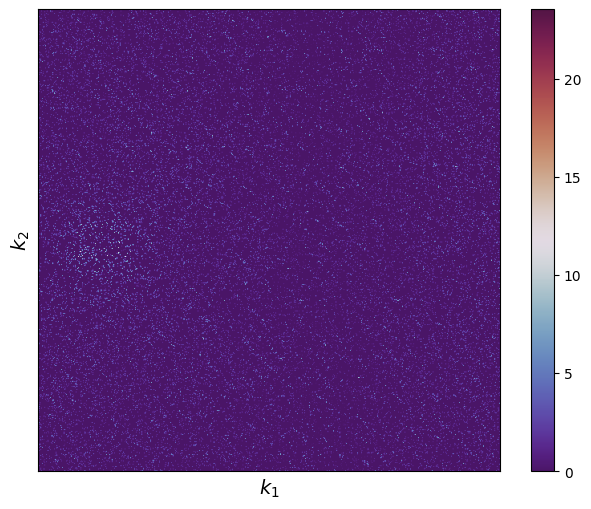

In [18]:
vertvis.plot_section(pred, 255, axis=3, figsize=(8,6))

## Evaluate

In [56]:
import numpy as np


In [84]:
# vertex reconstruction error
def reconstr_err(target: np.ndarray, pred: np.ndarray) -> float:
    return np.linalg.norm(pred - vertex) / np.linalg.norm(target)

recerr = reconstr_err(vertex, pred)
recerr

0.06782501212528207

In [ ]:
# eigenvalue reconstruction errors


eigenvalues, eigenvectors = np.linalg.eig(pred[:,:,0])
len(eigenvalues)

In [93]:
et, _ = np.linalg.eig(vertex[:,:,0])
ep, _ = np.linalg.eig(pred[:,:,0])
sorted(abs(et) - abs(ep))

[-16.603054854308738,
 -8.73705845531866,
 -6.047905939013205,
 -5.096497126487918,
 -4.0603994020076755,
 -3.437334866358647,
 -3.4278187822464403,
 -3.396372196458799,
 -3.3677542824526583,
 -2.8505365006967516,
 -2.823668178241393,
 -2.8217525135441406,
 -2.6220673415432216,
 -2.4426288425095706,
 -2.3578484465369183,
 -2.3027480266967224,
 -2.2220143601956255,
 -2.200687548866185,
 -2.1428611410338156,
 -2.1214966658602097,
 -2.0693617041357992,
 -2.023019165582013,
 -1.9820313497249349,
 -1.9265533934335526,
 -1.7446407141738831,
 -1.6362894411267455,
 -1.5986066074324925,
 -1.5238116025273243,
 -1.4974563263754108,
 -1.451441388232099,
 -1.4483221780295676,
 -1.392246150392741,
 -1.3918965853533534,
 -1.3913931561715165,
 -1.3838159191858055,
 -1.3612311033962579,
 -1.3535136655474256,
 -1.3535136655474256,
 -1.34155205642592,
 -1.3310056687461826,
 -1.3182741598726508,
 -1.3171121870598337,
 -1.304480888013221,
 -1.2270809972396535,
 -1.219796161835884,
 -1.1941885105421308,
 -1

In [ ]:
# -> different for different sections
v1, _ = np.linalg.eig(pred[:,:,2])
v2, _ = np.linalg.eig(pred[:,:,167])
sorted(abs(v1) - abs(v2))

[-5.159774691615382,
 -5.159774691615382,
 -2.670358603649456,
 -2.6452022895458676,
 -2.5365652374371646,
 -2.5365652374371646,
 -2.1973631753281104,
 -1.7622380593573803,
 -1.7145238676950103,
 -1.7145238676950103,
 -1.311740927100895,
 -1.311740927100895,
 -1.2613336869798286,
 -1.2431897554938165,
 -1.2431897554938165,
 -1.2282179235558845,
 -1.224065307041875,
 -1.1832460134965346,
 -1.1832460134965346,
 -1.1791063429646211,
 -1.1791063429646211,
 -1.1762217297304596,
 -1.1762217297304596,
 -1.1660999242415686,
 -1.1200112784989842,
 -1.06492727661748,
 -1.0227705531644466,
 -0.9889097686528343,
 -0.9781178504381902,
 -0.8937074027219114,
 -0.8710658920033509,
 -0.8172803314982096,
 -0.723009973726648,
 -0.6963801310527509,
 -0.6883332648033775,
 -0.6883332648033775,
 -0.6579163662863117,
 -0.5928350208042978,
 -0.5738081907704013,
 -0.5738081907704013,
 -0.5694149003925997,
 -0.5128420527715569,
 -0.49820122265309585,
 -0.48083723367562836,
 -0.4739914493171584,
 -0.4667365511272

In [73]:
# RMSE
def rmse(target: np.ndarray, pred: np.ndarray) -> float:
    return np.sqrt(np.square(target - pred).mean())

rmse_ = rmse(vertex, pred)
rmse_

0.2557820921515644

In [71]:
# relative errors
def rel_error(target: np.ndarray, pred: np.ndarray) -> float:
    return np.average(np.divide(np.abs(target - pred), np.abs(target)))

relerr = rel_error(vertex, pred)
relerr

0.045636286180477006

In [ ]:
# dimension compression rate
import math
from src.trainer import BaseTrainer

def compression_rate(trainer: BaseTrainer) -> float:
    in_dim = trainer.get_input_size()
    if not isinstance(in_dim, int):
        hidden = [math.prod(d) for d in trainer.config.hidden_dims]
        return min(hidden) / math.prod(in_dim)
    else:
        return min(trainer.config.hidden_dims) / in_dim

compr = compression_rate(trainer)
compr

0.07407407407407407